# 4.6. Dropout

In Section 4.5, we introduced the classical approach to regularizing statistical models by penalizing the  L2  norm of the weights. In probabilistic terms, we could justify this technique by arguing that we have assumed a prior belief that weights take values from a Gaussian distribution with mean zero. More intuitively, we might argue that we encouraged the model to spread out its weights among many features rather than depending too much on a small number of potentially spurious associations.

## 4.6.1. Overfitting Revisited

Faced with more features than examples, linear models tend to overfit. But given more examples than features, we can generally count on linear models not to overfit. Unfortunately, the reliability with which linear models generalize comes at a cost. Naively applied, linear models do not take into account interactions among features. For every feature, a linear model must assign either a positive or a negative weight, ignoring context.

In traditional texts, this fundamental tension between generalizability and flexibility is described as the bias-variance tradeoff. Linear models have high bias: they can only represent a small class of functions. However, these models have low variance: they give similar results across different random samples of the data.

Deep neural networks inhabit the opposite end of the bias-variance spectrum. Unlike linear models, neural networks are not confined to looking at each feature individually. They can learn interactions among groups of features. For example, they might infer that “Nigeria” and “Western Union” appearing together in an email indicates spam but that separately they do not.

Even when we have far more examples than features, deep neural networks are capable of overfitting. In 2017, a group of researchers demonstrated the extreme flexibility of neural networks by training deep nets on randomly-labeled images. Despite the absence of any true pattern linking the inputs to the outputs, they found that the neural network optimized by stochastic gradient descent could label every image in the training set perfectly. Consider what this means. If the labels are assigned uniformly at random and there are 10 classes, then no classifier can do better than 10% accuracy on holdout data. The generalization gap here is a whopping 90%. If our models are so expressive that they can overfit this badly, then when should we expect them not to overfit?

The mathematical foundations for the puzzling generalization properties of deep networks remain open research questions, and we encourage the theoretically-oriented reader to dig deeper into the topic. For now, we turn to the investigation of practical tools that tend to empirically improve the generalization of deep nets.

## 4.6.2. Robustness through Perturbations

Let us think briefly about what we expect from a good predictive model. We want it to peform well on unseen data. Classical generalization theory suggests that to close the gap between train and test performance, we should aim for a simple model. Simplicity can come in the form of a small number of dimensions. We explored this when discussing the monomial basis functions of linear models in Section 4.4. Additionally, as we saw when discussing weight decay ( L2  regularization) in Section 4.5, the (inverse) norm of the parameters also represents a useful measure of simplicity. Another useful notion of simplicity is smoothness, i.e., that the function should not be sensitive to small changes to its inputs. For instance, when we classify images, we would expect that adding some random noise to the pixels should be mostly harmless.

In 1995, Christopher Bishop formalized this idea when he proved that training with input noise is equivalent to Tikhonov regularization [Bishop, 1995]. This work drew a clear mathematical connection between the requirement that a function be smooth (and thus simple), and the requirement that it be resilient to perturbations in the input.

Then, in 2014, Srivastava et al. [Srivastava et al., 2014] developed a clever idea for how to apply Bishop’s idea to the internal layers of a network, too. Namely, they proposed to inject noise into each layer of the network before calculating the subsequent layer during training. They realized that when training a deep network with many layers, injecting noise enforces smoothness just on the input-output mapping.

Their idea, called dropout, involves injecting noise while computing each internal layer during forward propagation, and it has become a standard technique for training neural networks. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

To be clear, we are imposing our own narrative with the link to Bishop. The original paper on dropout offers intuition through a surprising analogy to sexual reproduction. The authors argue that neural network overfitting is characterized by a state in which each layer relies on a specifc pattern of activations in the previous layer, calling this condition co-adaptation. Dropout, they claim, breaks up co-adaptation just as sexual reproduction is argued to break up co-adapted genes.

The key challenge then is how to inject this noise. One idea is to inject the noise in an unbiased manner so that the expected value of each layer—while fixing the others—equals to the value it would have taken absent noise.

## 4.6.3. Dropout in Practice

Recall the MLP with a hidden layer and 5 hidden units in Fig. 4.1.1. When we apply dropout to a hidden layer, zeroing out each hidden unit with probability  p , the result can be viewed as a network containing only a subset of the original neurons. In Fig. 4.6.1,  h2  and  h5  are removed. Consequently, the calculation of the outputs no longer depends on  h2  or  h5  and their respective gradient also vanishes when performing backpropagation. In this way, the calculation of the output layer cannot be overly dependent on any one element of  h1,…,h5 .

Typically, we disable dropout at test time. Given a trained model and a new example, we do not drop out any nodes and thus do not need to normalize. However, there are some exceptions: some researchers use dropout at test time as a heuristic for estimating the uncertainty of neural network predictions: if the predictions agree across many different dropout masks, then we might say that the network is more confident.

## 4.6.4. Implementation from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 18., 20.,  0.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 4.6.4.1. Defining Model Parameters

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 4.6.4.2. Defining the Model

In [4]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 4.6.4.3. Training and Testing

RuntimeError: grad can be implicitly created only for scalar outputs

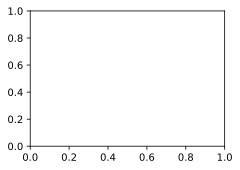

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.6.5. Concise Implementation

In [6]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

RuntimeError: grad can be implicitly created only for scalar outputs

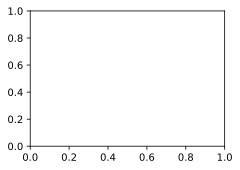

In [7]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.6.6. Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often they are used jointly.

Dropout replaces an activation  h  with a random variable with expected value  h .

Dropout is only used during training.